**deepHarvest**<br>
by $\text{Rishabh Pomaje}$

> *Problem Abstract*
- In any communication system, there always is a power constraint at the some point in the system be it due to hardware limitations, regulatory purposes, etc.
- This power constraint might be a stochastic quantity.
- The goal is then to learn a "good" system by using Neural Networks.

In [1]:
# Required Dependendencies 
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf 
%config InlineBackend.figure_format='svg'
print(f'NumPy ver.:{np.__version__}')
print(f'Tensorflow ver.:{tf.__version__}')

NumPy ver.:1.26.4
Tensorflow ver.:2.16.1


In [2]:
# System Specifications/ Definitions 
# uncoded block length 
k = 4
# Size of the alphabet
M = 2 ** k
# codeword length
n = 7
# Information rate
R = n / k

> Generation of the Training Data 

In [3]:
# 2^k dimensional One-Hot Encoded vectors will be used
training_data_size = 10 ** 6 # in number of blocks of k bits
sample_indices = np.random.randint(0, M, training_data_size)

# Set of One Hot Encoded Vectors :
x_train = []
for idx in sample_indices:
    temp = np.zeros(M)
    temp[idx] = 1
    x_train.append(temp)
    
x_train = tf.constant(x_train)
# Since we would like to reproduce the inputs as the outputs
y_train = x_train
# Change the Energy Harvesting Model Here :
energy_train = np.random.chisquare(3, (training_data_size, n))
print(energy_train)

[[3.89902159 1.28493155 0.80528293 ... 1.53692349 0.37058246 1.46964014]
 [2.4965788  2.77830676 3.53426613 ... 1.57993183 5.98279576 1.65966613]
 [2.940583   4.63698615 0.70987603 ... 7.13862581 1.98650356 0.38586061]
 ...
 [1.37335447 1.491019   0.32948939 ... 0.53137299 0.89437814 0.61143078]
 [5.67986105 5.12100443 0.31924594 ... 1.52727372 2.55273703 4.45779243]
 [3.81308533 4.39253973 0.29171172 ... 3.57317755 2.76111714 1.0110355 ]]


> Creating the Auto-Encoder Model 

In [4]:
# Describing the encoder layers :
input_layer = tf.keras.Input(shape=(M, ), name='Input_Layer')
enc_layer_01 = tf.keras.layers.Dense(M, activation='relu', name='Enc_Hidden_01')(input_layer)
enc_layer_02 = tf.keras.layers.Dense(n, activation='relu', name='Enc_Hidden_02')(enc_layer_01)
enc_layer_03 = tf.keras.layers.Dense(n, activation='linear', name='Enc_Hidden_03')(enc_layer_02)
# Normalizing the energy of the codeword to unity 
enc_layer_normalized = tf.keras.layers.Lambda((lambda x : tf.keras.backend.l2_normalize(x, axis=-1)), name='Unit_Normalizer')(enc_layer_03)
# Harvested Energy 
energy_input = tf.keras.Input(shape=(n,), name='Energy_Constraint')
boosted_signal = tf.keras.layers.Multiply(name='Energy_Booster')([enc_layer_normalized, energy_input])

# Describing the channel layers :
SNR_dB = 7
SNR_lin = 10 ** (SNR_dB / 10)
noisy_signal = tf.keras.layers.GaussianNoise(stddev=np.sqrt(np.mean(energy_train.flatten()) / (2 * 1 * SNR_lin)), name='AWGN_channel')(boosted_signal)

# Describing the decoder layers :
rx_signal = tf.keras.layers.Concatenate()([noisy_signal, energy_input])
dec_layer_01 = tf.keras.layers.Dense(8*M, activation='relu', name='Dec_Hidden_01')(rx_signal)
dec_layer_02 = tf.keras.layers.Dense(2*M, activation='relu', name='Dec_Hidden_02')(dec_layer_01)
dec_layer_03 = tf.keras.layers.Dense(M, activation='relu', name='Dec_Hidden_03')(dec_layer_02)
output_layer = tf.keras.layers.Dense(M, activation='softmax', name='Output_layer')(dec_layer_03)

autoencoder = tf.keras.Model(
    inputs = [input_layer, energy_input],
    outputs = [output_layer]
)
# Compiling the model :
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer         │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Hidden_01       │ (None, 16)        │        272 │ Input_Layer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Hidden_02       │ (None, 7)         │        119 │ Enc_Hidden_01[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Hidden_03       │ (None, 7)         │         56 │ Enc_Hidden_02[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unit_Normalizer     │ (None, 7)         │          0 │ Enc_Hidden_03[0]… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Energy_Constraint   │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Energy_Booster      │ (None, 7)         │          0 │ Unit_Normalizer[… │
│ (Multiply)          │                   │            │ Energy_Constrain… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel        │ (None, 7)         │          0 │ Energy_Booster[0… │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 14)        │          0 │ AWGN_channel[0][… │
│ (Concatenate)       │                   │            │ Energy_Constrain… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dec_Hidden_01       │ (None, 128)       │      1,920 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dec_Hidden_02       │ (None, 32)        │      4,128 │ Dec_Hidden_01[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dec_Hidden_03       │ (None, 16)        │        528 │ Dec_Hidden_02[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_layer        │ (None, 16)        │        272 │ Dec_Hidden_03[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,295 (28.50 KB)

 Trainable params: 7,295 (28.50 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# # To view the neural network as a block diagram uncomment the following :
# tf.keras.utils.plot_model(autoencoder, "images/energy_harvesting.png", show_shapes=True, show_layer_names=True, show_layer_activations=True, dpi=1000)

In [41]:
# Training the model on the _train data :
history = autoencoder.fit([x_train, energy_train], y_train, batch_size=1000, epochs=100)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6579 - loss: 1.0292
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9120 - loss: 0.2589
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9278 - loss: 0.2098
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9355 - loss: 0.1855
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9386 - loss: 0.1744
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9408 - loss: 0.1687
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9418 - loss: 0.1650
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9432 - loss: 0.1615
Epoch 9/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9443 - loss: 0.1576
Epoch 10/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9452 - loss: 0.1550
Epoch 11/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9449 - loss: 0.1545
Epoch 12/100
1000/1

> Testing the above learned system

In [43]:
# Abstracting out the Encoder :
encoder_model = tf.keras.Model(input_layer, enc_layer_normalized)

# Supposed received codeword at the receiver
decoder_input = tf.keras.Input(shape=(n,))
energy_constants = tf.keras.Input(shape=(n,))
decoder_output = autoencoder.layers[-5]([decoder_input, energy_constants])
decoder_output = autoencoder.layers[-4](decoder_output)
decoder_output = autoencoder.layers[-3](decoder_output)
decoder_output = autoencoder.layers[-2](decoder_output)
decoder_output = autoencoder.layers[-1](decoder_output)

# Abstracting out the Decoder :
decoder_model = tf.keras.Model([decoder_input, energy_constants], decoder_output)

- Generation of the testing/ validation data set

In [44]:
# 2^k dimensional One-Hot Encoded vectors will be used
testing_data_size = 10 ** 6 # in number of blocks of k bits
y_test = np.random.randint(0, M, testing_data_size)

# Set of One Hot Encoded Vectors :
# Generating training inputs :
x_test = np.zeros((testing_data_size, M))
x_test[np.arange(testing_data_size), y_test] = 1
    
print(x_test)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


> Validation Routine

In [45]:
# Range of Signal to Noise Ratio :
# in dB :
SNR_dB = np.linspace(-4, 8, 25)
# in Linear Scale :
SNR_lin = 10 ** (SNR_dB / 10)
# Fixing energy per bit :
E_b = 3 
# Range of noise variance accordingly :
noise_var = E_b / (2 * 1 * SNR_lin) 

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 105s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 45s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 26s 824us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 25s 796us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 26s 815us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 108s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step
31250/31250 ━━━━━━━━━━━━━━

In [ ]:
# Testing the learned model on validation data :
BLER_learned = []
for noise in noise_var :
    # Encoding using our model :
    encoded_signal = encoder_model.predict(x_test)
    # Boosting Signal according to the energy harvested 
    energy_train = np.random.chisquare(3, size=(testing_data_size, n))
    tx_signal = energy_train * encoded_signal
    # AWGN Noise :
    awgn = np.random.normal(0, np.sqrt(noise), (testing_data_size, n))
    rx_signal_noisy = tx_signal + awgn
    # Decoding using our model :
    decoded_signal = decoder_model.predict([rx_signal_noisy, energy_train])
    estimated_vectors = np.argmax(decoded_signal, axis=-1)
    BLER_learned.append(np.sum(estimated_vectors != y_test) / testing_data_size)

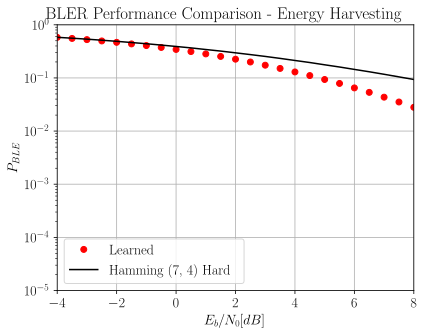

In [48]:
plt.rcParams.update({
    "text.usetex": True, # Comment this line if TeX is not installed on your machine.
    "font.family" : 'serif',
    "font.size": 14
})
BLER_hard = [0.581305, 0.559514, 0.536377, 0.512669, 0.488556, 0.4638, 0.439983, 0.415272, 0.391009, 0.367479, 0.342623, 0.320251, 0.296759, 0.274935, 0.253964, 0.233205, 0.213085, 0.194969, 0.17669, 0.160559, 0.144689, 0.130624, 0.117148, 0.104638, 0.093506]
fig, axes = plt.subplots()
axes.semilogy(SNR_dB, BLER_learned, label='Learned', color='red', marker="o", ls=" ")
axes.semilogy(SNR_dB, BLER_hard, label='Hamming (7, 4) Hard', color='black', ls="-")
axes.set_xlabel(r'$E_b / N_0[dB]$')
axes.set_ylabel(r'$P_{BLE}$')
axes.set_xlim(-4, 8)
axes.set_ylim(10**-5, 10**0)
axes.set_title(f'BLER Performance Comparison - Energy Harvesting')
axes.legend()
axes.grid()

> Recording any values for future reference

In [51]:
# Saving any plots/ diagrams
fig.savefig("plots/deepHarvest.svg", transparent=True)

# Saving the BLER values :
with open("results/results_deepHarvest.txt", mode='w') as file_id :
    file_id.write(f'BLER_learned = {BLER_learned}\n')
    file_id.write(f'BLER_hard = {BLER_hard}')